In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

import pyroundtrip as pyrt
print("Currently use version v%s of Roundtrip."%pyrt.__version__)

2025-07-14 09:46:53.729335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752511613.743173 1958453 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752511613.747431 1958453 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752511613.760028 1958453 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752511613.760039 1958453 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752511613.760041 1958453 computation_placer.cc:177] computation placer alr

Currently use version v2.0.1 of Roundtrip.


In [3]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [4]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [6]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64) 
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train_3d = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train_3d[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val_3d = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val_3d[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [8]:
# Generate test set with fixed noise level
x_test_3d = np.zeros((num_test, 64, 64,64))
for i in range(num_test):
    x_test_3d[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [11]:
y_test_3d = np.zeros((x_test_3d.shape[0],64,64,64))
y_train_3d = np.zeros((x_train_3d.shape[0],64,64,64))
y_val_3d = np.zeros((x_val_3d.shape[0],64,64,64))

for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)

for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
print("y generated")

y generated


In [12]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            buffer_scale=1.10):
    """
    Projects all input and output 3D densities to 2D RGB with shared normalization.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        buffer_scale: float, buffer for normalization (default 10%)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    # Convert all to RGB (unnormalized)
    x_train_rgb = split_sum_rgb(x_train_3d)
    x_val_rgb   = split_sum_rgb(x_val_3d)
    x_test_rgb  = split_sum_rgb(x_test_3d)
    y_train_rgb = split_sum_rgb(y_train_3d)
    y_val_rgb   = split_sum_rgb(y_val_3d)
    y_test_rgb  = split_sum_rgb(y_test_3d)

    # Compute global max
    global_max = np.max([
        x_train_rgb.max(), x_val_rgb.max(), x_test_rgb.max(),
        y_train_rgb.max(), y_val_rgb.max(), y_test_rgb.max()
    ])
    buffered_max = global_max * buffer_scale

    # Normalize all
    def normalize(x_rgb):
        return np.clip(x_rgb / buffered_max, 0, 1)

    return (
        normalize(x_train_rgb), normalize(x_val_rgb), normalize(x_test_rgb),
        normalize(y_train_rgb), normalize(y_val_rgb), normalize(y_test_rgb)
    )


In [13]:
x_train_rgb, x_val_rgb, x_test_rgb, y_train_rgb, y_val_rgb, y_test_rgb = batch_project_3d_to_rgb(
    x_train_3d, x_val_3d, x_test_3d,
    y_train_3d, y_val_3d, y_test_3d,
    buffer_scale=1.10
)




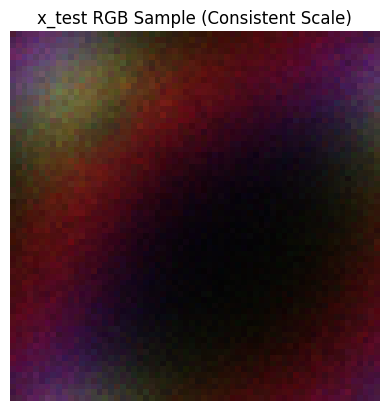

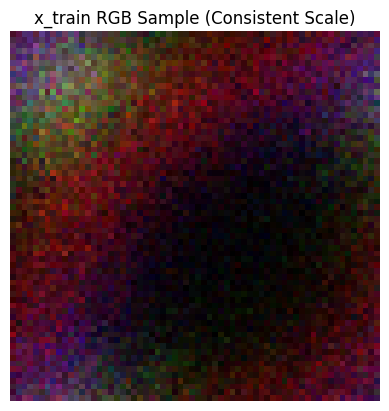

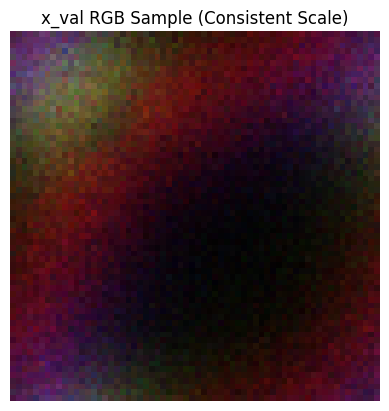

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_test_rgb[0])
plt.title("x_test RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()
plt.imshow(x_train_rgb[0])
plt.title("x_train RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()
plt.imshow(x_val_rgb[0])
plt.title("x_val RGB Sample (Consistent Scale)")
plt.axis('off')
plt.show()

In [16]:
print("here")

here


In [30]:
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_working_directory)


Current Working Directory: /global/u2/k/kberard/SCGSR/Research/EDDAE/Diamond/Testing/2D/Roundtrip


In [31]:
import yaml
params = yaml.safe_load(open('/global/u2/k/kberard/SCGSR/Research/EDDAE/Diamond/Testing/2D/Roundtrip/config/config_dm.yaml', 'r'))
print(params)

{'dataset': 'cifar10', 'output_dir': '.', 'x_dim': 32, 'z_dim': 10, 'lr': 0.0002, 'alpha': 10, 'beta': 1, 'gamma': 0, 'g_d_freq': 1, 'g_units': [64, 32], 'e_units': [32, 64], 'dz_units': [20, 10], 'dx_units': [32, 16], 'save_model': True, 'sd_x': 0.05, 'scale': 0.5, 'sample_size': 20000}


In [32]:
model = pyrt.RoundtripTV_img(params=params,random_seed=123)

In [33]:
print(x_train_rgb.shape)

(5000, 64, 64, 3)


In [ ]:
model.train(data=x_train_rgb[:,:32,:32,:], save_format='npy', n_iter=100000, batches_per_eval=5000)

/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'discriminator_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Iteration [0] : e_loss_adv [1.4036], g_loss_adv [0.9597], l2_loss_z [0.9865],                l2_loss_x [0.8055], g_e_loss [20.2836], dz_loss [0.8182], dx_loss [0.5327], d_loss [1.3510]
Saving checkpoint for iteration 0 at ./checkpoints/cifar10/20250714_100655/ckpt-0
Iteration [5000] : e_loss_adv [0.1673], g_loss_adv [0.1484], l2_loss_z [0.0004],                l2_loss_x [0.4723], g_e_loss [5.0426], dz_loss [0.1661], dx_loss [0.1772], d_loss [0.3434]
Saving checkpoint for iteration 5000 at ./checkpoints/cifar10/20250714_100655/ckpt-5000
Iteration [10000] : e_loss_adv [0.1608], g_loss_adv [0.1654], l2_loss_z [0.0003],                l2_loss_x [0.4716], g_e_loss [5.0447], dz_loss [0.1618], dx_loss [0.1612], d_loss [0.3229]
Saving checkpoint for iteration 10000 at ./checkpoints/cifar10/20250714_100655/ckpt-10000
Iteration [15000] : e_loss_adv [0.1586], g_loss_adv [0.1468], l2_loss_z [0.0003],                l2_loss_x [0.4713], g_e_loss [5.0216], dz_loss [0.1613], dx_loss [0.1549], d_loss [